# example: Keras 1D convolutional neural network on SUSY data

# SUSY Data Set

- <https://archive.ics.uci.edu/ml/datasets/SUSY>
- <http://arxiv.org/abs/1402.4735>

The SUSY Data Set is a classification problem to distinguish between a signal process which produces supersymmetric particles and a background process which does not. In the data, the first column is the class label (1 for signal, 0 for background), followed by 18 features (8 low-level features and 10 high-level features):

- lepton 1 pT
- lepton 1 eta
- lepton 1 phi
- lepton 2 pT
- lepton 2 eta
- lepton 2 phi
- missing energy magnitude
- missing energy phi
- MET_rel
- axial MET
- M_R
- M_TR_2
- R
- MT2
- S_R
- M_Delta_R
- dPhi_r_b
- cos(theta_r1)

This data has been produced by MadGraph5 Monte Carlo simulations of 8 TeV proton collisions, with showering and hadronisation performed by Pythia 6 and detector response simulated by Delphes. The first 8 features are kinematic properties measured by simulated particle detectors. The next 10 features are functions of the first 8 features; they are high-level features derived by physicists to help discriminate between the two classes. There are 46% positive examples in the SUSY data set. The features were standardised over the entire training/testing sets with mean zero and standard deviation one, except for those features with values strictly greater than zero; these were scaled such that the mean value was one.

In [1]:
import datetime
import keras
from keras import activations
from keras.datasets import mnist
from keras.layers import Dense, Flatten
from keras.layers import Conv1D, Conv2D, MaxPooling1D, MaxPooling2D, Dropout
from keras.models import Sequential
from keras.utils import plot_model
import matplotlib.pylab as plt
import pandas as pd
import numpy as np
import pandas as pd
from sklearn.metrics import auc, roc_curve
from sklearn.model_selection import train_test_split
import seaborn as sns
sns.set(style = 'ticks')
sns.set_palette('husl')
import talos as ta
from vis.visualization import visualize_activation
from vis.visualization import visualize_saliency
from vis.utils import utils

Using TensorFlow backend.


In [2]:
%matplotlib inline
plt.rcParams["figure.figsize"] = [17, 12]

In [20]:
df = pd.read_csv(
    "SUSY_100k.csv",
    names = [
        "classification",
        "lepton_1_pT",
        "lepton_1_eta",
        "lepton_1_phi",
        "lepton_2_pT",
        "lepton_2_eta",
        "lepton_2_phi",
        "missing_energy_magnitude",
        "missing_energy_phi",
        "MET_rel",
        "axial_MET",
        "M_R",
        "M_TR_2",
        "R",
        "MT2",
        "S_R",
        "M_Delta_R",
        "dPhi_r_b",
        "cos_theta_r1"
    ]
)
df_raw = df
df.head()

,classification,lepton_1_pT,lepton_1_eta,lepton_1_phi,lepton_2_pT,lepton_2_eta,lepton_2_phi,missing_energy_magnitude,missing_energy_phi,MET_rel,axial_MET,M_R,M_TR_2,R,MT2,S_R,M_Delta_R,dPhi_r_b,cos_theta_r1
0,0.0,0.972861,0.653855,1.176225,1.157156,-1.739873,-0.874309,0.567765,-0.175000,0.810061,-0.252552,1.921887,0.889637,0.410772,1.145621,1.932632,0.994464,1.367815,0.040714
1,1.0,1.667973,0.064191,-1.225171,0.506102,-0.338939,1.672543,3.475464,-1.219136,0.012955,3.775174,1.045977,0.568051,0.481928,0.000000,0.448410,0.205356,1.321893,0.377584
2,1.0,0.444840,-0.134298,-0.709972,0.451719,-1.613871,-0.768661,1.219918,0.504026,1.831248,-0.431385,0.526283,0.941514,1.587535,2.024308,0.603498,1.562374,1.135454,0.180910
3,1.0,0.381256,-0.976145,0.693152,0.448959,0.891753,-0.677328,2.033060,1.533041,3.046260,-1.005285,0.569386,1.015211,1.582217,1.551914,0.761215,1.715464,1.492257,0.090719
4,1.0,1.309996,-0.690089,-0.676259,1.589283,-0.693326,0.622907,1.087562,-0.381742,0.589204,1.365479,1.179295,0.968218,0.728563,0.000000,1.083158,0.043429,1.154854,0.094859


In [4]:
df.describe()

,classification,lepton_1_pT,lepton_1_eta,lepton_1_phi,lepton_2_pT,lepton_2_eta,lepton_2_phi,missing_energy_magnitude,missing_energy_phi,MET_rel,axial_MET,M_R,M_TR_2,R,MT2,S_R,M_Delta_R,dPhi_r_b,cos_theta_r1
count,100000.00000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,1.000000e+05,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,1.000000e+05
mean,0.45975,1.002520,-0.001214,0.001130,0.998765,-0.002327,0.001986,1.002132,-0.001027,1.001774e+00,0.001874,1.001381,1.000968,0.998835,1.002564,1.000301,1.002018,0.996392,2.255094e-01
std,0.49838,0.682332,1.005256,1.003296,0.649669,1.004957,1.000790,0.876802,1.001608,8.878220e-01,1.005287,0.624153,0.584931,0.471350,0.860436,0.616290,0.624171,0.436301,1.977076e-01
min,0.00000,0.255649,-2.102649,-1.734744,0.428590,-2.059240,-1.733849,0.000709,-1.727112,9.238942e-07,-10.582791,0.272967,0.009538,0.018478,0.000000,0.074357,0.004657,0.000008,2.388670e-07
25%,0.00000,0.563566,-0.764006,-0.868199,0.595844,-0.775816,-0.864801,0.480474,-0.865236,3.711455e-01,-0.491849,0.589816,0.620144,0.649552,0.169395,0.598758,0.515733,0.685564,6.905427e-02
50%,0.00000,0.792447,-0.001697,0.000985,0.798784,-0.003995,0.002508,0.775232,-0.013274,8.020215e-01,-0.078552,0.828958,0.879155,0.933930,0.906571,0.835261,0.917300,1.089616,1.681940e-01
75%,1.00000,1.209686,0.762437,0.872140,1.160556,0.769450,0.867590,1.207878,0.869245,1.373204e+00,0.352210,1.213489,1.222236,1.279828,1.615310,1.209476,1.385430,1.366626,3.303397e-01
max,1.00000,12.620587,2.101403,1.734717,13.107124,2.059317,1.734670,13.959188,1.740672,1.450629e+01,14.342724,13.969072,13.200295,5.335464,12.791473,14.024200,10.329440,1.591660,1.000000e+00


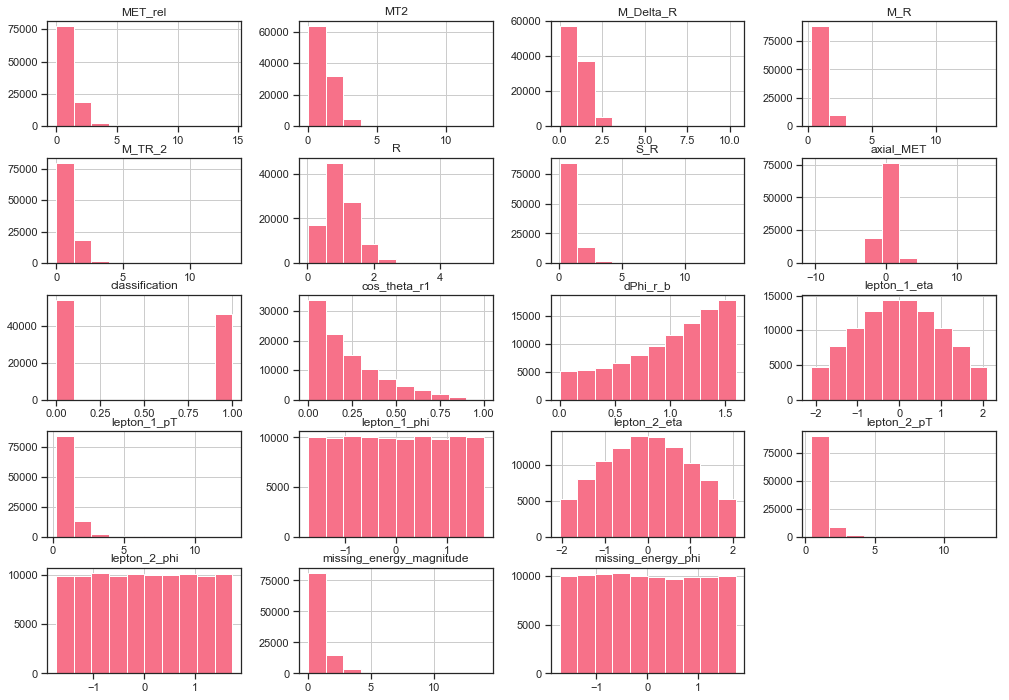

In [5]:
df.hist();

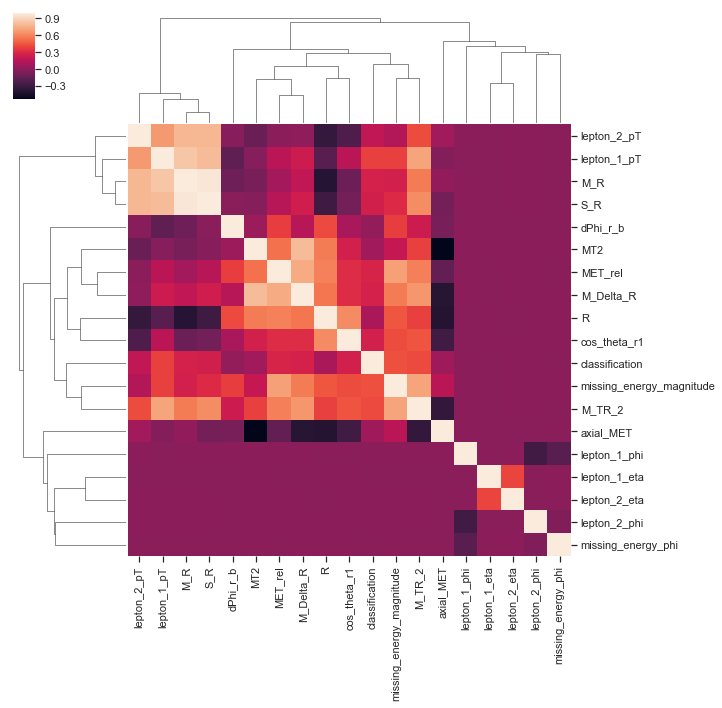

In [6]:
plot = sns.clustermap(df.corr())
_ = plt.setp(plot.ax_heatmap.get_yticklabels(), rotation = 0)

In [7]:
#sns.pairplot(df, hue = "classification");

In [8]:
df['labels'] = df['classification'].astype('category').cat.codes
x = df.drop(columns = ['classification', 'labels']).values.astype('float32')
y = df['classification']
# Convert class vectors to binary class matrices using 1 hot encoding.
# 0 ---> 1, 0, 0
# 1 ---> 0, 1, 0
# 2 ---> 0, 0, 1
num_classes = len(y.unique())
y_raw = y # non-categorical
y = keras.utils.to_categorical(y, len(y.unique()))

x = np.asarray(x)
y = np.asarray(y)

x = x.reshape(len(x), 18, 1)

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.1, shuffle = True)

In [9]:
# Define a callback class which is to be passed to the model fitting function
# as an element of a list of possible callbacks.
class AccuracyHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs = {}):
        self.acc = []
        self.val_acc = []
    def on_epoch_end(self, batch, logs = {}):
        self.acc.append(logs.get('acc'))
        self.val_acc.append(logs.get('val_acc'))

class NBatchLogger(keras.callbacks.Callback):
    """
    A Logger that log average performance per `display` steps.
    """
    def __init__(self, display):
        self.step = 0
        self.display = display
        self.metric_cache = {}

    def on_batch_end(self, batch, logs={}):
        self.step += 1
        for k in self.params['metrics']:
            if k in logs:
                self.metric_cache[k] = self.metric_cache.get(k, 0) + logs[k]
        if self.step % self.display == 0:
            metrics_log = ''
            for (k, v) in self.metric_cache.items():
                val = v / self.display
                if abs(val) > 1e-3:
                    metrics_log += ' - %s: %.4f' % (k, val)
                else:
                    metrics_log += ' - %s: %.4e' % (k, val)
            print('step: {}/{} ... {}'.format(self.step,
                                          self.params['steps'],
                                          metrics_log))
            self.metric_cache.clear()
        
history = AccuracyHistory()

In [10]:
model = Sequential()
model.add(Conv1D(32, (5), strides = (1), input_shape = (18, 1), activation = 'relu'))
model.add(MaxPooling1D(pool_size = (2), strides = (2)))
model.add(Conv1D(32, (3), strides = (1), input_shape = (18, 1), activation = 'relu'))
#model.add(Dropout(rate = 0.5))
model.add(Flatten())
model.add(Dense(300,                                            activation = 'relu'))
#model.add(Dropout(rate = 0.5))
model.add(Dense(300,                                            activation = 'relu'))
model.add(Dropout(rate = 0.5))
model.add(Dense(num_classes,                                    activation = 'softmax'))
model.compile(loss = "categorical_crossentropy", optimizer = "nadam", metrics = ['accuracy'])
#plot_model(model, to_file = "model.png")
model.summary()

epochs     = 100
batch_size = 256

model.fit(
    x_train,
    y_train,
    batch_size      = batch_size,
    epochs          = epochs,
    verbose         = True,
    validation_data = (x_test, y_test),
    callbacks       = [history]
)

score = model.evaluate(x_test, y_test, verbose = False)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 14, 32)            192       
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 7, 32)             0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 5, 32)             3104      
_________________________________________________________________
flatten_1 (Flatten)          (None, 160)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 300)               48300     
_________________________________________________________________
dense_2 (Dense)              (None, 300)               90300     
_________________________________________________________________
dropout_1 (Dropout)          (None, 300)               0         
__________

90000/90000 [==============================] - 1s 12us/step - loss: 0.3210 - acc: 0.8485 - val_loss: 0.6358 - val_acc: 0.7747
Epoch 50/100
90000/90000 [==============================] - 1s 12us/step - loss: 0.3175 - acc: 0.8511 - val_loss: 0.6264 - val_acc: 0.7793
Epoch 51/100
90000/90000 [==============================] - 1s 12us/step - loss: 0.3148 - acc: 0.8514 - val_loss: 0.6462 - val_acc: 0.7737
Epoch 52/100
90000/90000 [==============================] - 1s 12us/step - loss: 0.3103 - acc: 0.8531 - val_loss: 0.6637 - val_acc: 0.7751
Epoch 53/100
90000/90000 [==============================] - 1s 13us/step - loss: 0.3086 - acc: 0.8549 - val_loss: 0.6512 - val_acc: 0.7745
Epoch 54/100
90000/90000 [==============================] - 1s 12us/step - loss: 0.3059 - acc: 0.8552 - val_loss: 0.6714 - val_acc: 0.7713
Epoch 55/100
90000/90000 [==============================] - 1s 12us/step - loss: 0.3038 - acc: 0.8578 - val_loss: 0.6854 - val_acc: 0.7708
Epoch 56/100
90000/90000 [==============

test loss: 1.0753770990848541
test accuracy: 0.7544


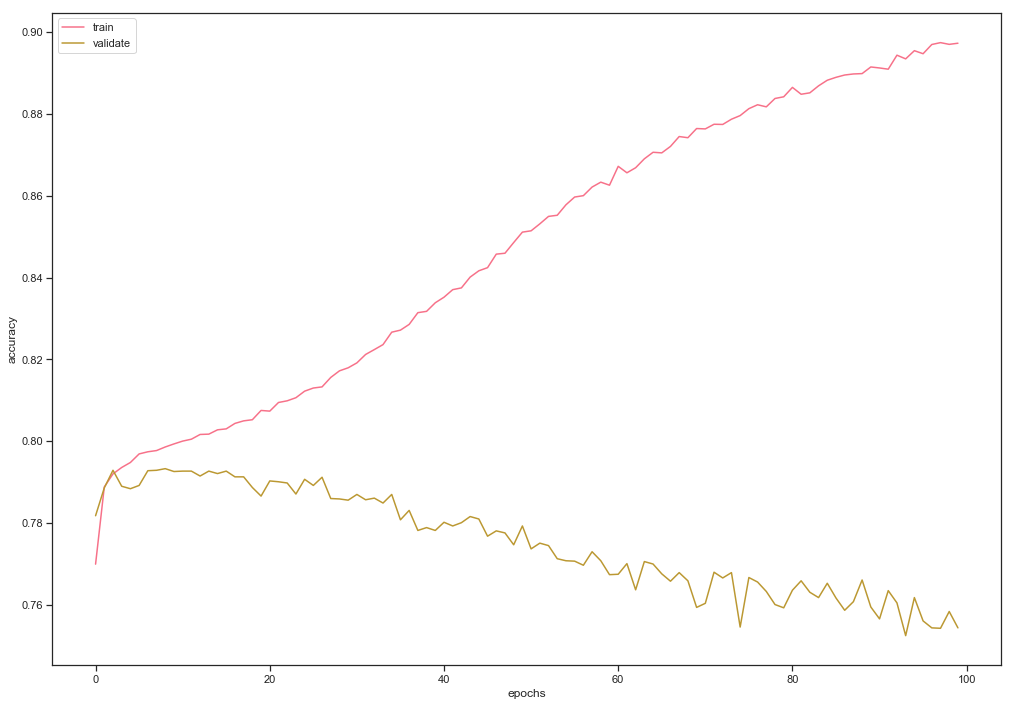

In [11]:
print('test loss:', score[0])
print('test accuracy:', score[1])
plt.plot(history.acc, label='train')
plt.plot(history.val_acc, label='validate')
plt.legend()
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.show()

In [12]:
y_pred = model.predict(x_test)

y_test_non_categorical = np.argmax(y_test, axis=1)
y_pred_non_categorical = np.argmax(y_pred, axis=1)

fpr, tpr, thresholds = roc_curve(y_test_non_categorical, y_pred_non_categorical)
auc_data = auc(fpr, tpr)

##plt.plot([0, 1], [0, 1], 'k--')
#plt.plot(fpr, tpr, label = 'model (area = {:.3f})'.format(auc_data))
#plt.xlabel('false positive rate')
#plt.ylabel('true positive rate')
#plt.title('ROC curve')
##plt.legend(loc = 'best')
#plt.show()

In [13]:
df = pd.DataFrame(columns = ["y_test", "y_pred"])
df["y_test"] = y_test_non_categorical.tolist()
df["y_pred"] = y_pred_non_categorical.tolist()
df["equal"]  = df.apply(lambda row: "correct" if row["y_test"] == row["y_pred"] else "incorrect", axis = 1)
df["equal"].value_counts() / len(df)

correct      0.7544
incorrect    0.2456
Name: equal, dtype: float64

  0%|          | 0/4 [00:00<?, ?it/s]

{'batch_size': 256, 'epochs': 50, 'dropout': 0.5, 'activation': 'tanh', 'dense_1': 50, 'optimizer': 'nadam', 'losses': 'categorical_crossentropy'}
test loss: 0.4447196405569712
test accuracy: 0.7944666666666667


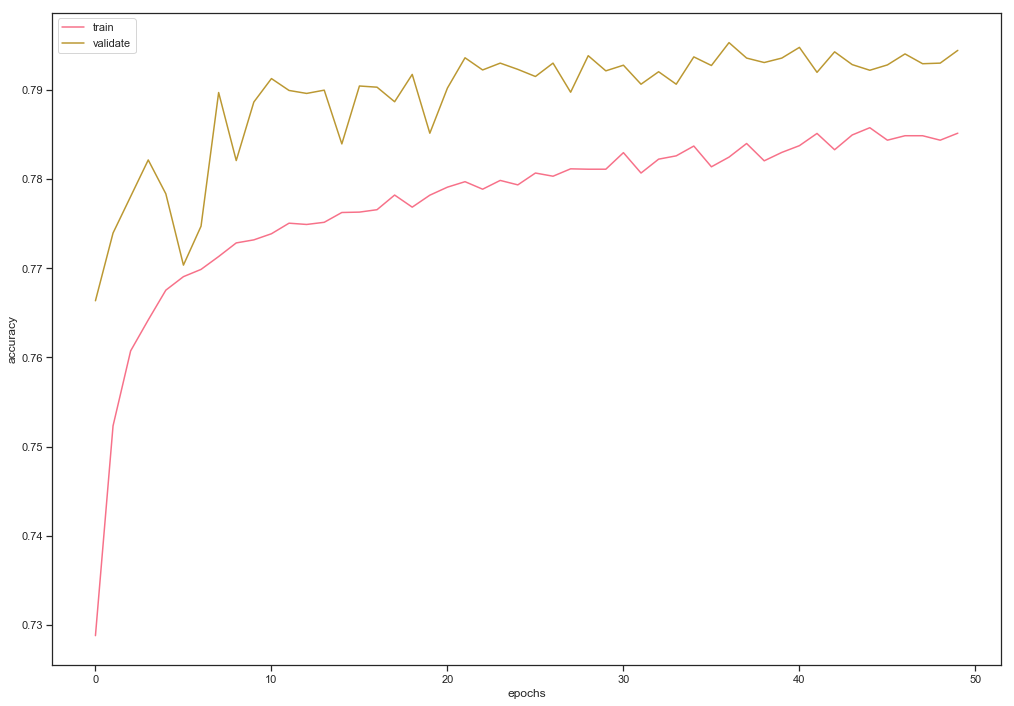

 25%|██▌       | 1/4 [00:53<02:41, 53.75s/it]

{'batch_size': 256, 'epochs': 50, 'dropout': 0.5, 'activation': 'relu', 'dense_1': 50, 'optimizer': 'nadam', 'losses': 'categorical_crossentropy'}
test loss: 0.4500562926928202
test accuracy: 0.7875666666666666


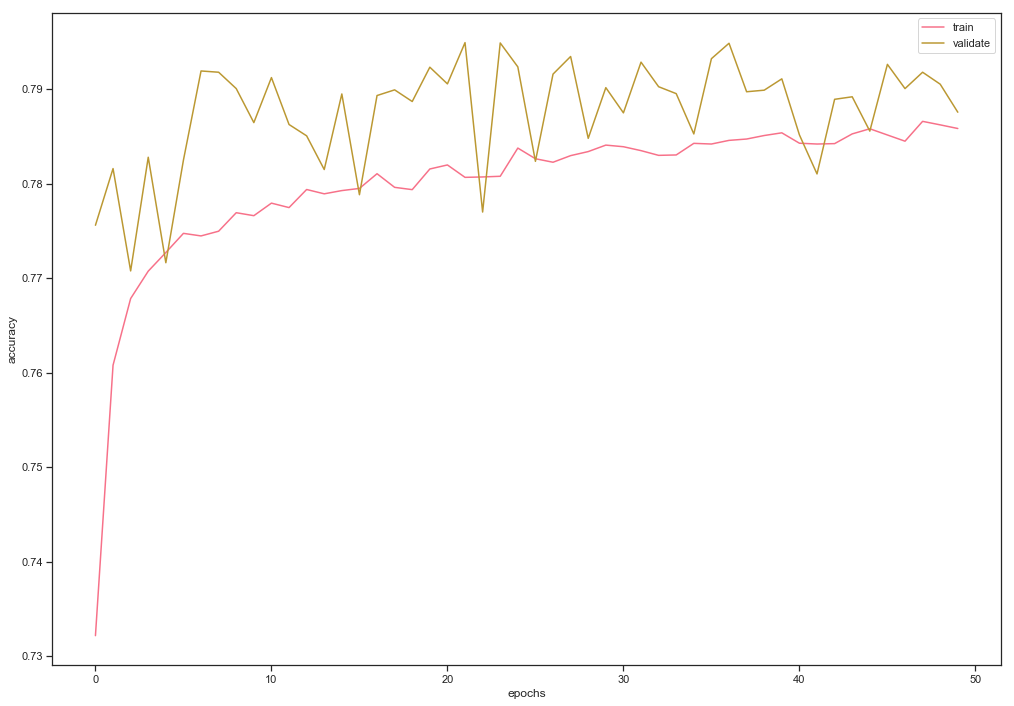

 50%|█████     | 2/4 [01:47<01:47, 53.66s/it]

{'batch_size': 256, 'epochs': 50, 'dropout': 0.5, 'activation': 'relu', 'dense_1': 100, 'optimizer': 'nadam', 'losses': 'categorical_crossentropy'}
test loss: 0.4450766045888265
test accuracy: 0.7934333333333333


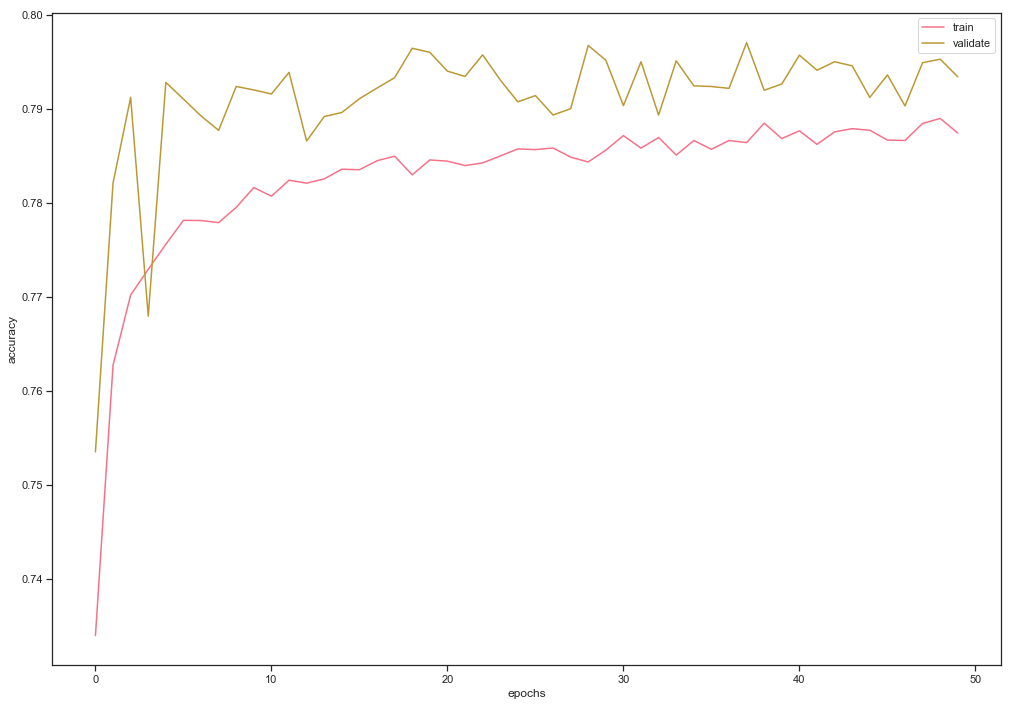

 75%|███████▌  | 3/4 [02:41<00:53, 53.71s/it]

{'batch_size': 256, 'epochs': 50, 'dropout': 0.5, 'activation': 'tanh', 'dense_1': 100, 'optimizer': 'nadam', 'losses': 'categorical_crossentropy'}
test loss: 0.4490584668636322
test accuracy: 0.7902333333333333


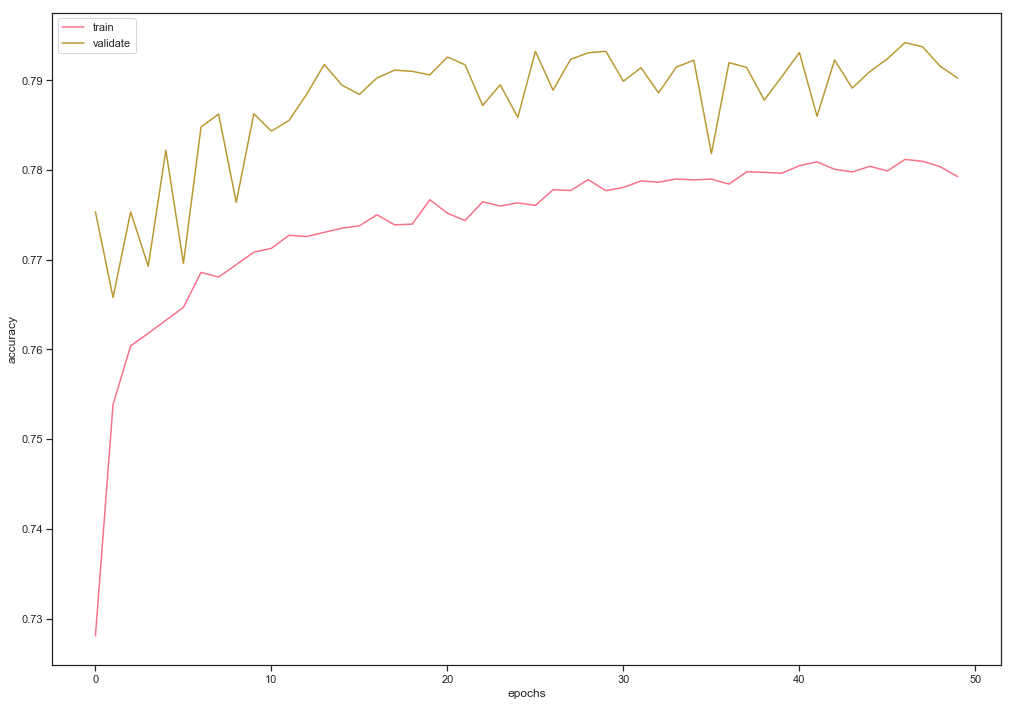

100%|██████████| 4/4 [03:35<00:00, 53.83s/it]


In [14]:
parameters = {
    'batch_size': [256],
    'epochs'    : [50],
    'dropout'   : [0.5],
    'activation': ['tanh', 'relu'],
    'dense_1'   : [50, 100],
    'optimizer' : ['nadam'],
    'losses'    : ['categorical_crossentropy'],
}

def hmodel_convolutional(
    x_train,
    y_train,
    x_test,
    y_test,
    parameters = parameters
    ):
    model = Sequential()
    model.add(Conv1D(32, (5), strides = (1), input_shape = (18, 1), activation = parameters['activation']))
    model.add(Dropout(rate = parameters['dropout']))
    model.add(MaxPooling1D(pool_size = (2), strides = (2)))
    #model.add(Dropout(rate = parameters['dropout']))
    model.add(Conv1D(32, (3), strides = (1), input_shape = (18, 1), activation = parameters['activation']))
    model.add(Dense(parameters['dense_1'],                          activation = parameters['activation']))
    #model.add(Dropout(rate = parameters['dropout']))
    model.add(Flatten())
    model.add(Dense(parameters['dense_1'],                          activation = parameters['activation']))
    #model.add(Dropout(rate = parameters['dropout']))
    model.add(Dense(parameters['dense_1'],                          activation = parameters['activation']))
    model.add(Dropout(rate = parameters['dropout']))
    model.add(Dense(num_classes,                                    activation = 'softmax'))
    model.compile(
        loss      = parameters['losses'],
        optimizer = parameters['optimizer'],
        metrics   = ['accuracy']
    )
    #filepath = datetime.datetime.utcnow().strftime("%Y-%m-%dT%H%M%SZ") + ".png"
    #plot_model(model, to_file = filepath)
    #plot_model(model, to_file = "model.png")
    #print(model.summary())
    out = model.fit(
        x_train,
        y_train,
        batch_size      = parameters['batch_size'],
        epochs          = parameters['epochs'],
        verbose         = False,
        validation_data = [x_test, y_test],
        callbacks       = [history]
    )
    score = model.evaluate(x_test, y_test, verbose = False)
    print('test loss:', score[0])
    print('test accuracy:', score[1])
    plt.plot(history.acc, label='train')
    plt.plot(history.val_acc, label='validate')
    plt.legend()
    plt.xlabel('epochs')
    plt.ylabel('accuracy')
    plt.show()
    return out, model

h = ta.Scan(
    x                = x,
    y                = y,
    params           = parameters,
    dataset_name     = 'SUSY',
    experiment_no    = '1',
    model            = hmodel_convolutional,
    grid_downsample  = 1,
    #reduction_method = None
    reduction_method = 'correlation',
    print_params     = True
)

In [15]:
r = ta.Reporting(h)
r.data.sort_values(by = ['acc'], ascending = False)

,round_epochs,val_loss,val_acc,loss,acc,batch_size,epochs,dropout,activation,dense_1,optimizer,losses
2,50,0.440579,0.797067,0.452961,0.789000,256,50,0.5,relu,100,nadam,categorical_crossentropy
1,50,0.442297,0.794933,0.456324,0.786600,256,50,0.5,relu,50,nadam,categorical_crossentropy
0,50,0.442194,0.795333,0.460418,0.785786,256,50,0.5,tanh,50,nadam,categorical_crossentropy
3,50,0.446575,0.794200,0.466796,0.781186,256,50,0.5,tanh,100,nadam,categorical_crossentropy


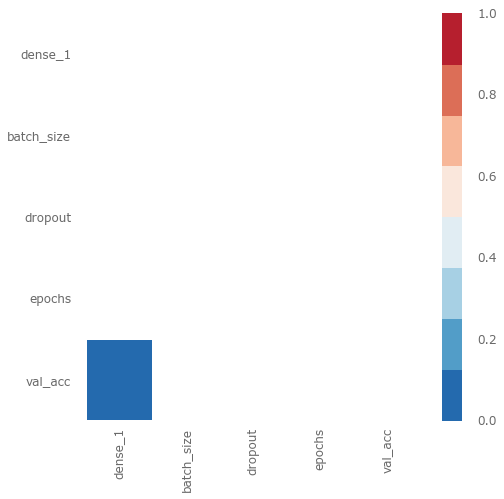

In [16]:
r.plot_corr()

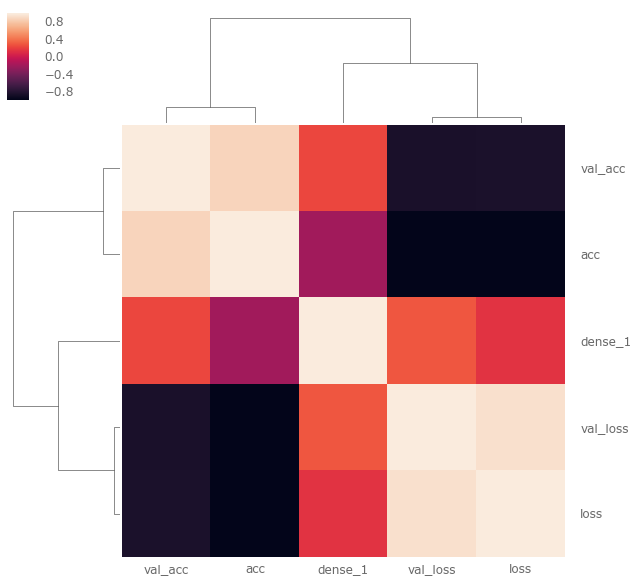

In [17]:
_df = r.data[['val_loss', 'val_acc', 'loss', 'acc', 'dense_1']]
plot = sns.clustermap(_df.corr())
_ = plt.setp(plot.ax_heatmap.get_yticklabels(), rotation = 0)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 14, 32)            192       
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 7, 32)             0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 5, 32)             3104      
_________________________________________________________________
flatten_1 (Flatten)          (None, 160)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 300)               48300     
_________________________________________________________________
dense_2 (Dense)              (None, 300)               90300     
_________________________________________________________________
dropout_1 (Dropout)          (None, 300)               0         
__________

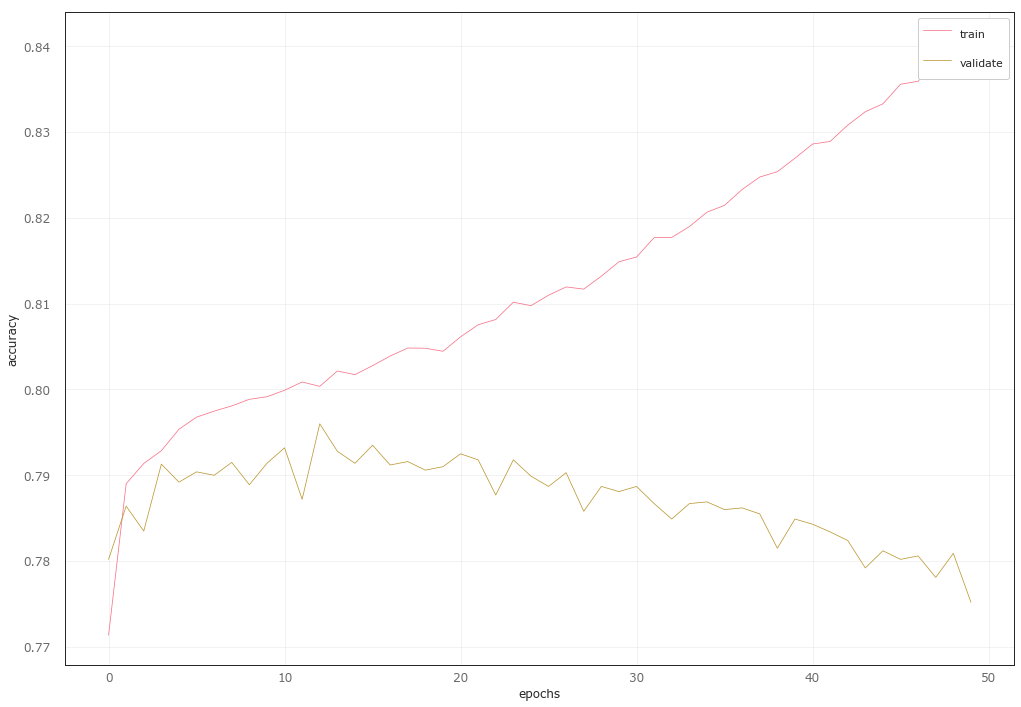

In [18]:
model = Sequential()
model.add(Conv1D(32, (5), strides = (1), input_shape = (18, 1), activation = 'relu'))
model.add(MaxPooling1D(pool_size = (2), strides = (2)))
model.add(Conv1D(32, (3), strides = (1), input_shape = (18, 1), activation = 'relu'))
#model.add(Dropout(rate = 0.5))
model.add(Flatten())
model.add(Dense(300,                                            activation = 'relu'))
#model.add(Dropout(rate = 0.5))
model.add(Dense(300,                                            activation = 'relu'))
model.add(Dropout(rate = 0.5))
model.add(Dense(num_classes,                                    activation = 'softmax', name = "preds"))
model.compile(loss = "categorical_crossentropy", optimizer = "nadam", metrics = ['accuracy'])
#plot_model(model, to_file = "model.png")
model.summary()

epochs     = 50
batch_size = 256

model.fit(
    x_train,
    y_train,
    batch_size      = batch_size,
    epochs          = epochs,
    verbose         = False,
    validation_data = (x_test, y_test),
    callbacks       = [history]
)

score = model.evaluate(x_test, y_test, verbose = False)

print('test loss:', score[0])
print('test accuracy:', score[1])
plt.plot(history.acc, label='train')
plt.plot(history.val_acc, label='validate')
plt.legend()
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.show()

# activation maximization

In [21]:
layer_idx = utils.find_layer_idx(model, 'preds')
model.layers[layer_idx].activation = activations.linear # Swap softmax for linear.
model = utils.apply_modifications(model)

# class 0 (background)
filter_idx = 0
img_0 = visualize_activation(model, layer_idx, filter_indices=0) #verbose=True
img_1 = visualize_activation(model, layer_idx, filter_indices=1) #verbose=True

_df = pd.DataFrame()
_df["features"] = df.columns.tolist()[1:]#[:-1] #list(range(1, len(img) + 1))
_df["activation_class_0"] = img_0
_df["activation_class_1"] = img_1

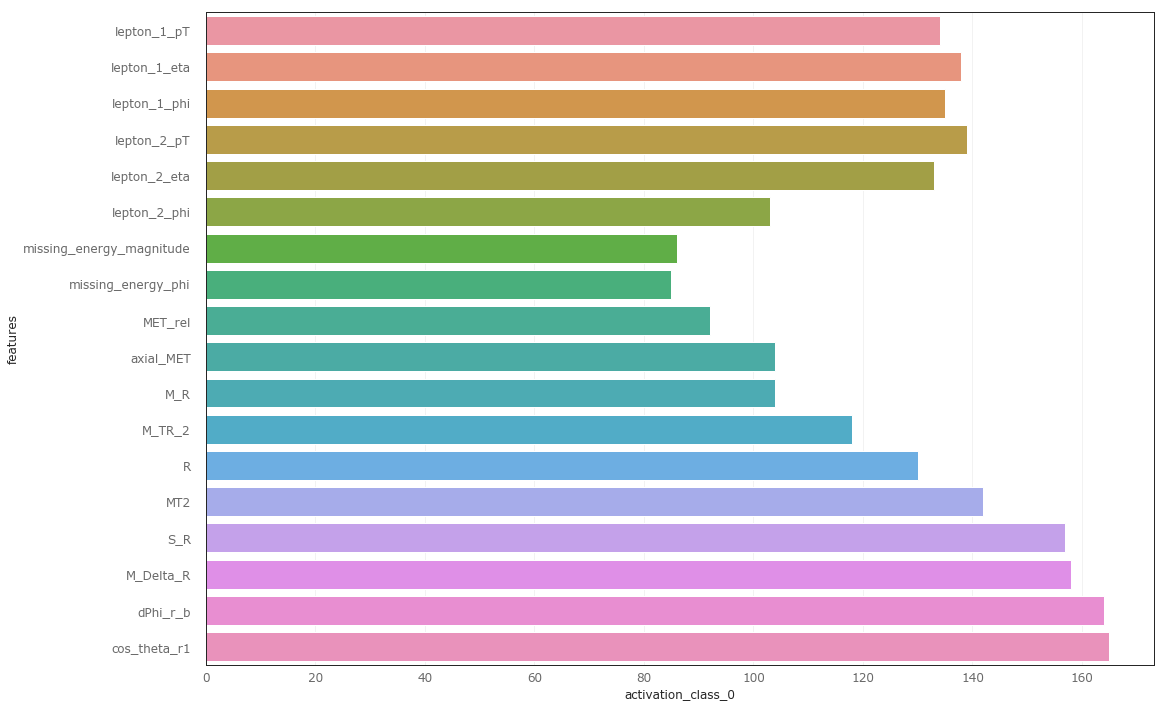

In [22]:
sns.barplot(_df["activation_class_0"], _df["features"]);

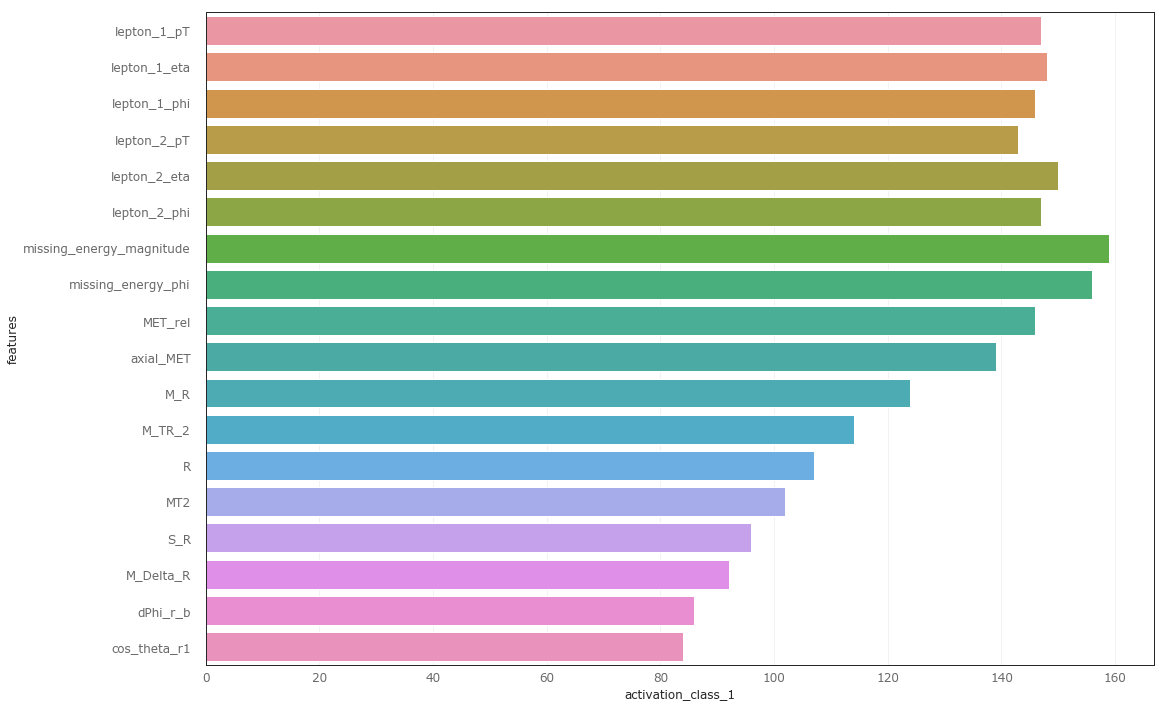

In [23]:
sns.barplot(_df["activation_class_1"], _df["features"]);

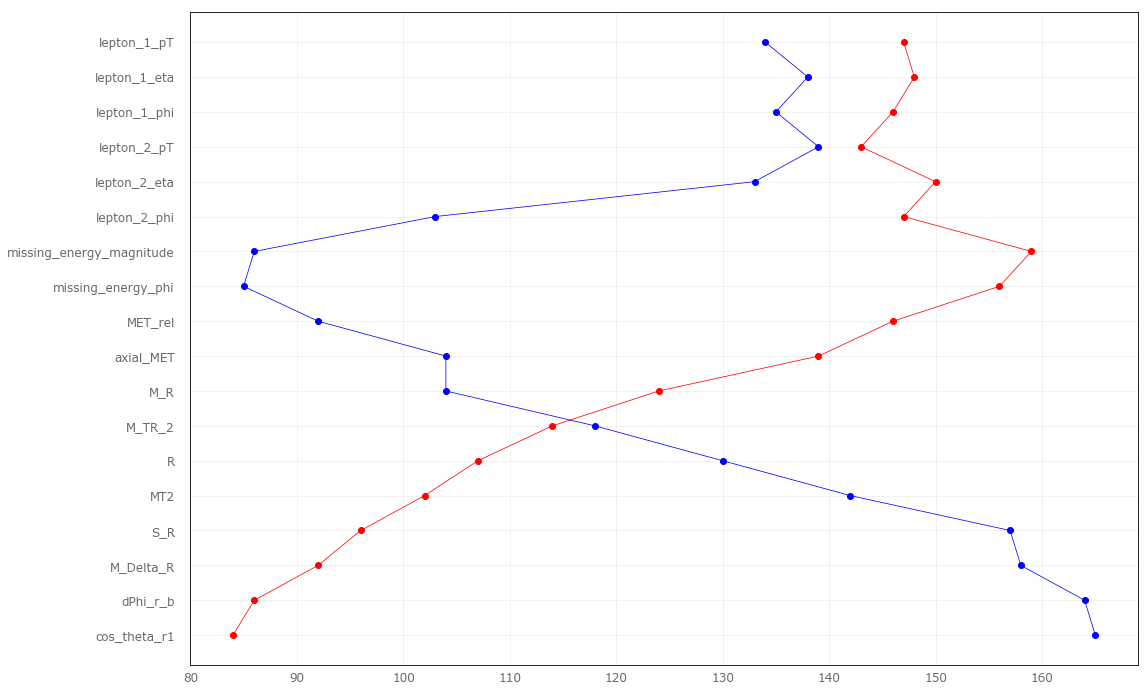

In [24]:
#ax = sns.scatterplot(_df["activation_class_1"], _df["features"], color="red");
#sns.scatterplot(_df["activation_class_0"], _df["features"], color="blue");

ax = plt.plot(_df["activation_class_1"], _df["features"], marker='o', color='red')
plt.plot(_df["activation_class_0"], _df["features"], marker='o', color='blue')
plt.gca().invert_yaxis()
plt.show()

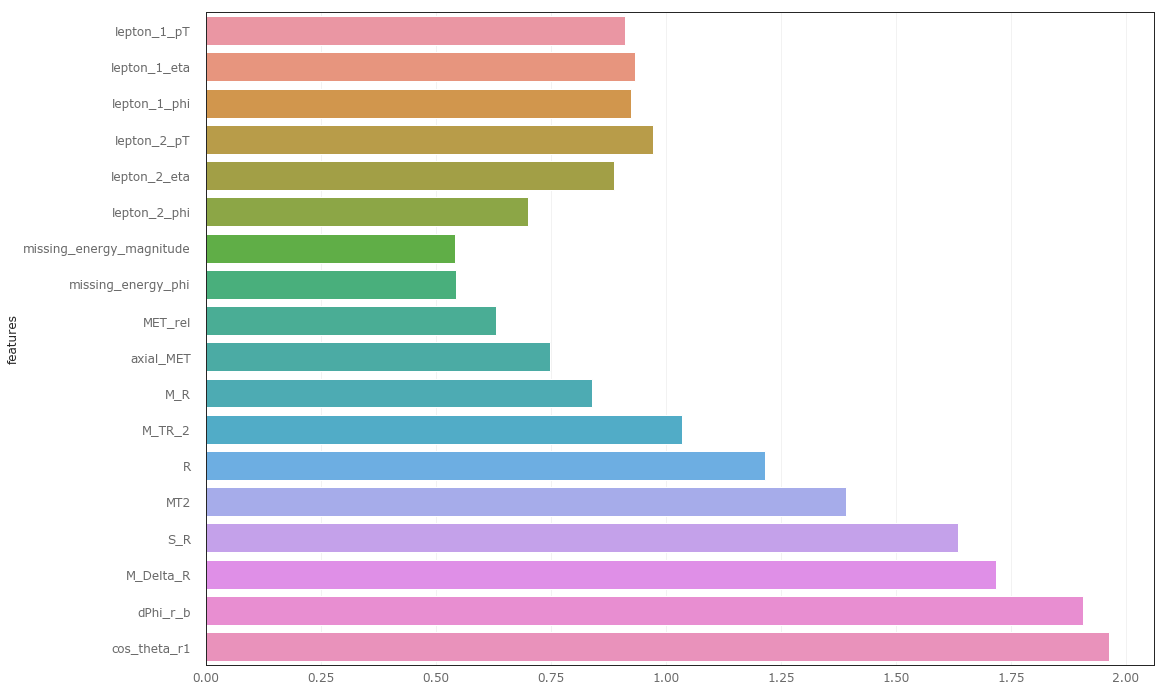

In [25]:
sns.barplot(_df["activation_class_0"] / _df["activation_class_1"], _df["features"]);

# saliency

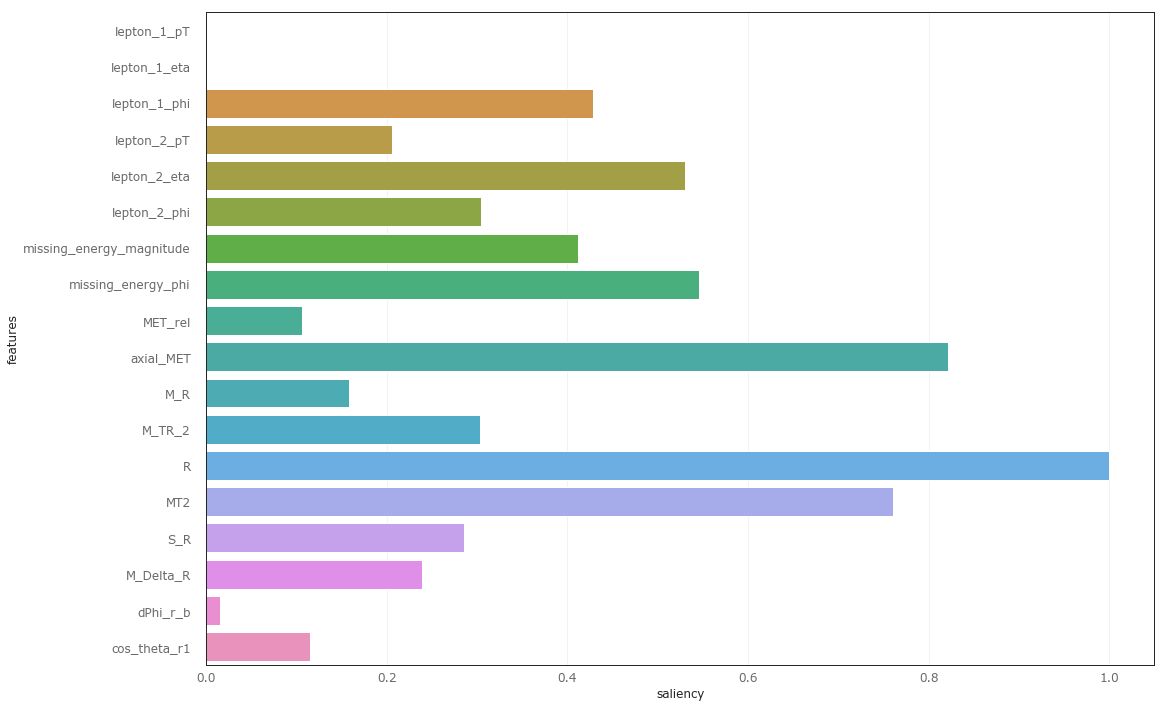

In [26]:
grads = visualize_saliency(model, layer_idx, filter_indices=filter_idx, seed_input=x_test[13], backprop_modifier='guided')
_df["saliency"] = grads.tolist()
sns.barplot(_df["saliency"], _df["features"]);